# **Cassava Leaf Disease Classification**

This project is on kaggle competition Cassava Leaf Disease Classification. Identify the type of disease present in Cassava Leaf image. This competition, has a dataset of 21,367 labeled images collected during a regular survey in Uganda.The task is to classify each cassava image into four disease categories or a fifth category indicating a healthy leaf. So that, farmers may be able to quickly identify diseased plants, potentially saving their crops before they inflict irreparable damage.

This is a Computer Vision problem where we have to try differernt CV models.Submissions are evaluated based on their categorization accuracy.

# **Data Set**

**Files:**

[train/test]_images : the image files. Roughly 15,000 images in the test set.

[train/test]_tfrecords : the image files in tfrecord format.

sample_submission.csv : A properly formatted sample submission, given the disclosed test set content.

label_num_to_disease_map.json : The mapping between each disease code and the real disease name.

**train.csv**

image_id : the image file name.

label : the ID code for the disease.

# **1. Reading Data**

## **1.1 Loading Data**

In [ ]:
#checking GPU
import nvidia_smi
!nvidia-smi

Sun May 15 14:20:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
pip install albumentations==1.1.0

     |████████████████████████████████| 102 kB 5.0 MB/s 
     |████████████████████████████████| 47.8 MB 101 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
pip install opencv-python==4.5.4.60

     |████████████████████████████████| 60.3 MB 47 kB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [ ]:
pip install timm

     |████████████████████████████████| 431 kB 3.4 MB/s 


### **1.1.1 CASSAVA CFG**

In [ ]:
class CASSAVA:
  error = False
  freq_print = 100
  cpu = 4
  cv_model = 'tf_efficientnet_b5_ns'
  image_size = 512
  learning_rate_sch='CosineAnnealingWarmRestarts'     
  no_epc = 10
  cosine_annealing = 10 # CosineAnnealingWarmRestarts
  learning_rate = 1e-4
  min_learning_rate = 1e-6
  data_batch = 8
  wd = 1e-6
  maximum_gradient = 1000
  random_seed = 42
  number_of_labels = 5
  label_column='label'
  kfold_no = 5
  kfold = [0, 1, 2, 3, 4]
  tr=True
  inf=False

### **1.1.2 Libraries and Modules**

In [ ]:
import os
import math
import time
import random
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import sys
sys.path.append('./pytorch-image-models-master')
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
import scipy as sp
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
from tqdm.auto import tqdm
from functools import partial
import cv2
from PIL import Image
from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose,
    MotionBlur,
    MedianBlur,
    GaussianBlur,
    )
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform
import timm
from google.colab import drive
import warnings 
warnings.filterwarnings('ignore')

In [ ]:
cuda = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
cuda

device(type='cpu')

In [ ]:
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/MyDrive/cassava")

Mounted at /content/gdrive


### **1.1.4 Directory Settings**

In [ ]:
OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
  os.makedirs(OUTPUT_DIR)

TRAIN_PATH = 'input/train_images'
TEST_PATH = 'input/test_images'

### **1.1.5 Cassava Train and Test Data**

In [ ]:
cassava_data = pd.read_csv('train.csv')
cassava_test = pd.read_csv('sample_submission.csv')
cassava_to_disease_id = pd.read_json('label_num_to_disease_map.json', 
                         orient='index')

In [ ]:
print(cassava_to_disease_id[0][0])

Cassava Bacterial Blight (CBB)


In [ ]:
if CASSAVA.error:
  CASSAVA.no_epc = 1
  cassava_data = cassava_data.sample(n=1000, random_state=CASSAVA.randoom_seed).reset_index(drop=True)

In [ ]:
cassava_data.head()

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

In [ ]:
cassava_test.head()

image_id  label
0  2216849948.jpg      4

In [ ]:
cassava_to_disease_id.head()

0
0       Cassava Bacterial Blight (CBB)
1  Cassava Brown Streak Disease (CBSD)
2           Cassava Green Mottle (CGM)
3         Cassava Mosaic Disease (CMD)
4                              Healthy

# **2. EDA**

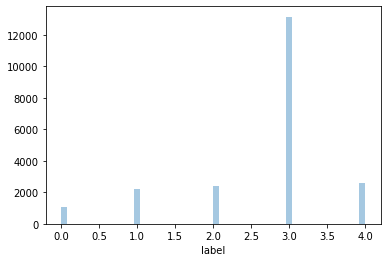

In [ ]:
sns.distplot(cassava_data['label'], kde=False)

In [ ]:
cassava_data['label'].value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

In [ ]:
np.round((cassava_data['label'].value_counts()/len(cassava_data['label']))*100, 2)

3    61.49
4    12.04
2    11.15
1    10.23
0     5.08
Name: label, dtype: float64

## **2.0 Disease 0/CBB Leaves**

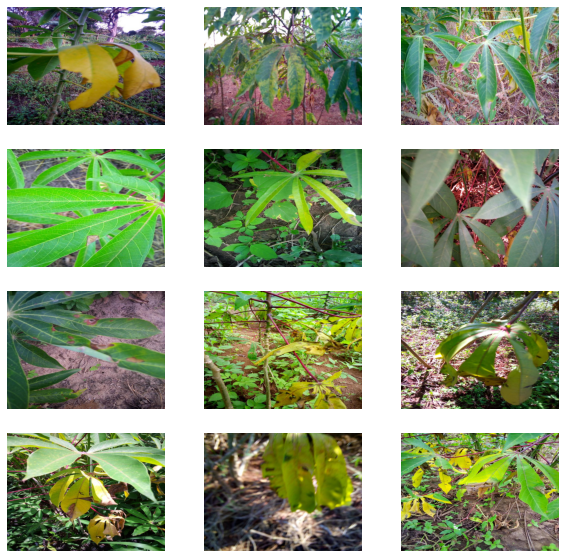

In [ ]:
cassava_sample = cassava_data[cassava_data.label == 0].sample(12)
plt.figure(figsize=(10,10))
for index, (id, label) in enumerate(zip(cassava_sample.image_id, cassava_sample.label)):
  plt.subplot(4, 3, index + 1)
  cassava_img = cv2.imread(os.path.join(TRAIN_PATH, id))
  cassava_img = cv2.cvtColor(cassava_img, cv2.COLOR_BGR2RGB)
  plt.imshow(cassava_img)
  plt.axis("off")

## **2.1 Disease 1/CBSD Leaves**

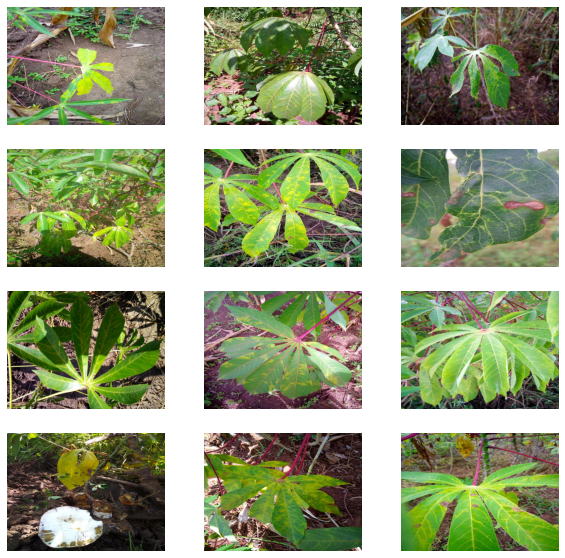

In [ ]:
cassava_sample = cassava_data[cassava_data.label == 1].sample(12)
plt.figure(figsize=(10,10))
for index, (id, label) in enumerate(zip(cassava_sample.image_id, cassava_sample.label)):
  plt.subplot(4, 3, index + 1)
  cassava_img = cv2.imread(os.path.join(TRAIN_PATH, id))
  cassava_img = cv2.cvtColor(cassava_img, cv2.COLOR_BGR2RGB)
  plt.imshow(cassava_img)
  plt.axis("off")

## **2.2 Disease 2/CGM Leaves**

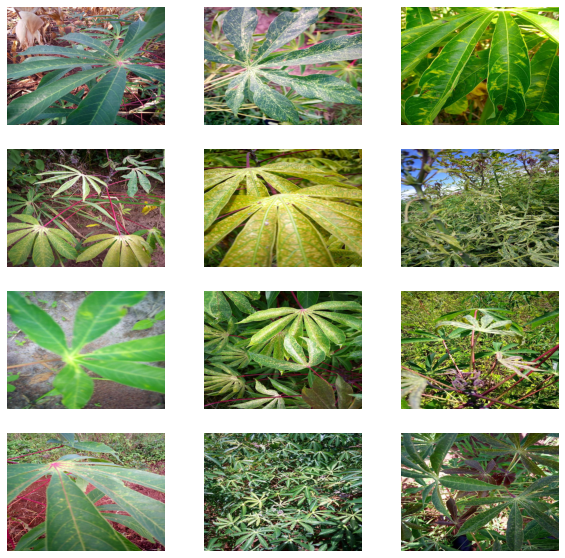

In [ ]:
cassava_sample = cassava_data[cassava_data.label == 2].sample(12)
plt.figure(figsize=(10,10))
for index, (id, label) in enumerate(zip(cassava_sample.image_id, cassava_sample.label)):
  plt.subplot(4, 3, index + 1)
  cassava_img = cv2.imread(os.path.join(TRAIN_PATH, id))
  cassava_img = cv2.cvtColor(cassava_img, cv2.COLOR_BGR2RGB)
  plt.imshow(cassava_img)
  plt.axis("off")

## **2.3 Disease 3/CMD Leaves**

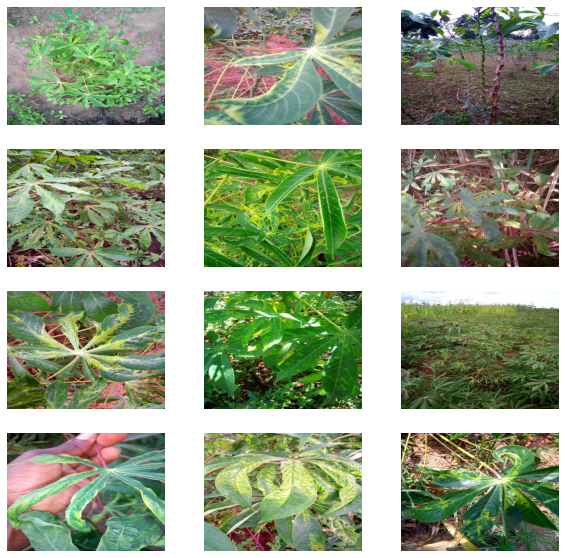

In [ ]:
cassava_sample = cassava_data[cassava_data.label == 3].sample(12)
plt.figure(figsize=(10,10))
for index, (id, label) in enumerate(zip(cassava_sample.image_id, cassava_sample.label)):
  plt.subplot(4, 3, index + 1)
  cassava_img = cv2.imread(os.path.join(TRAIN_PATH, id))
  cassava_img = cv2.cvtColor(cassava_img, cv2.COLOR_BGR2RGB)
  plt.imshow(cassava_img)
  plt.axis("off")

## **2.4 Healthy Leaves**

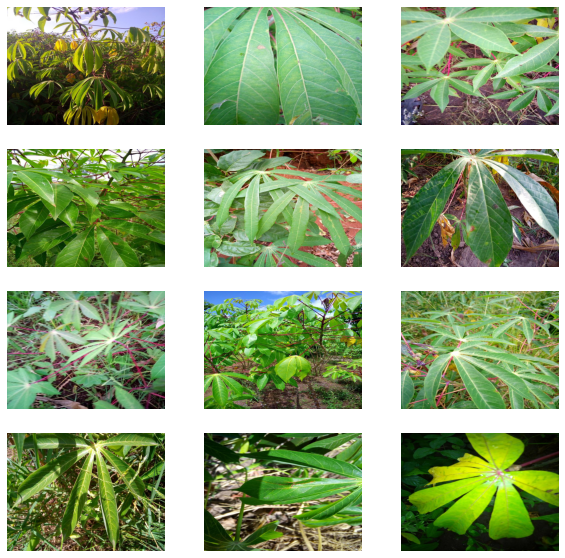

In [ ]:
cassava_sample = cassava_data[cassava_data.label == 4].sample(12)
plt.figure(figsize=(10,10))
for index, (id, label) in enumerate(zip(cassava_sample.image_id, cassava_sample.label)):
  plt.subplot(4, 3, index + 1)
  cassava_img = cv2.imread(os.path.join(TRAIN_PATH, id))
  cassava_img = cv2.cvtColor(cassava_img, cv2.COLOR_BGR2RGB)
  plt.imshow(cassava_img)
  plt.axis("off")

# **3. Cross Validation Split and Utility functions**

In [ ]:
cassava_data_kfolds = cassava_data.copy()
kfolds = StratifiedKFold(n_splits=CASSAVA.kfold_no, shuffle=True, random_state=CASSAVA.random_seed)
for k_number, (tr_idx, val_idx) in enumerate(kfolds.split(cassava_data_kfolds, cassava_data_kfolds[CASSAVA.label_column])):
    cassava_data_kfolds.loc[val_idx, 'fold'] = int(k_number)
cassava_data_kfolds['fold'] = cassava_data_kfolds['fold'].astype(int)
print(cassava_data_kfolds.groupby(['fold', CASSAVA.label_column]).size())

fold  label
0     0         218
      1         438
      2         477
      3        2631
      4         516
1     0         218
      1         438
      2         477
      3        2631
      4         516
2     0         217
      1         438
      2         477
      3        2632
      4         515
3     0         217
      1         438
      2         477
      3        2632
      4         515
4     0         217
      1         437
      2         478
      3        2632
      4         515
dtype: int64


In [ ]:
cassava_data_kfolds

image_id  label  fold
0      1000015157.jpg      0     3
1      1000201771.jpg      3     2
2       100042118.jpg      1     2
3      1000723321.jpg      1     1
4      1000812911.jpg      3     2
...               ...    ...   ...
21392   999068805.jpg      3     1
21393   999329392.jpg      3     0
21394   999474432.jpg      1     1
21395   999616605.jpg      4     2
21396   999998473.jpg      4     4

[21397 rows x 3 columns]

In [ ]:
def cassava_scr(label_true, label_pred):
  return accuracy_score(label_true, label_pred)


@contextmanager
def timer(name):
  start_time = time.time()
  CASSAVA_LOG.info(f'[{name}] start')
  yield
  CASSAVA_LOG.info(f'[{name}] done in {time.time() - start_time:.0f} s.')


def cassava_init_log(file=OUTPUT_DIR+'cassava_log.log'):
  from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
  logs = getLogger(__name__)
  logs.setLevel(INFO)
  stream = StreamHandler()
  stream.setFormatter(Formatter("%(message)s"))
  files = FileHandler(filename=file)
  files.setFormatter(Formatter("%(message)s"))
  logs.addHandler(stream)
  logs.addHandler(files)
  return logs

CASSAVA_LOG = cassava_init_log()


def rseed(rseed=42):
  random.seed(rseed)
  os.environ['PYTHONHASHSEED'] = str(rseed)
  np.random.seed(rseed)
  torch.manual_seed(rseed)
  torch.cuda.manual_seed(rseed)
  torch.backends.cudnn.deterministic = True

rseed(CASSAVA.random_seed)

# **4. Cassava Train and Test Datasets Classes**

In [ ]:
class Dataset_Train_Cassava(Dataset):
  def __init__(self, data, transform=None):
    self.data = data
    self.image_id = data['image_id'].values
    self.disease_no = data['label'].values
    self.transform = transform
        
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    image_id = self.image_id[index]
    image_id_path = f'{TRAIN_PATH}/{image_id}'
    cassava_img = cv2.imread(image_id_path)
    cassava_img = cv2.cvtColor(cassava_img, cv2.COLOR_BGR2RGB)
        
        
    if self.transform:
      cassava_transform = self.transform(image=cassava_img)
      cassava_img = cassava_transform['image']
    disease_no = torch.tensor(self.disease_no[index]).long()
    return cassava_img, disease_no
    

class Dataset_Test_Cassava(Dataset):
  def __init__(self, data, transform=None):
    self.data = data
    self.image_id = data['image_id'].values
    self.transform = transform
        
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    image_id = self.image_id[index]
    image_id_path = f'{TEST_PATH}/{image_id}'
    cassava_img = cv2.imread(image_id_path)
    cassava_img = cv2.cvtColor(cassava_img, cv2.COLOR_BGR2RGB)
        
    if self.transform:
      cassava_img = cassava_img.astype(np.float32)
      cassava_transform = self.transform(image=cassava_img)
      cassava_img = cassava_transform['image']
    return cassava_img

In [ ]:
cassava_train = Dataset_Train_Cassava(cassava_data, transform=None)
for index in range(10):
  cassava_img, disease_no = cassava_train[index]
  plt.imshow(cassava_img)
  plt.title(f'disease_no: {disease_no}')
  plt.show() 

Output hidden; open in https://colab.research.google.com to view.

# **5. Cassava Augmentation Function**

In [ ]:
def cassava_augmentation(*, df):
    
    if df == 'train':
        return Compose([
        RandomResizedCrop(CASSAVA.image_size, CASSAVA.image_size),
        OneOf([RandomBrightness(limit=(0.1), p=0.5), RandomContrast(limit=(0.1), p=0.5)], p=1,),
        OneOf([MotionBlur(blur_limit=3), MedianBlur(blur_limit=3), GaussianBlur(blur_limit=3),], p=0.5,),
        VerticalFlip(p=0.5),
        HorizontalFlip(p=0.5),
        ShiftScaleRotate(
            shift_limit=0.2,
            scale_limit=0.2,
            rotate_limit=20,
            interpolation=cv2.INTER_LINEAR,
            border_mode=cv2.BORDER_REFLECT_101,
            p=1,
        ),
        Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0),
        ToTensorV2(),
        ])

    elif df == 'valid':
        return Compose([
            Resize(CASSAVA.image_size, CASSAVA.image_size),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

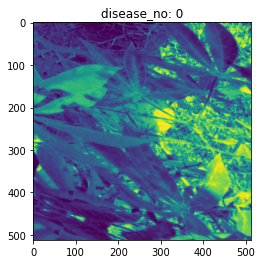

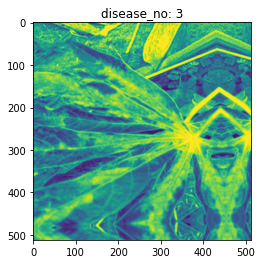

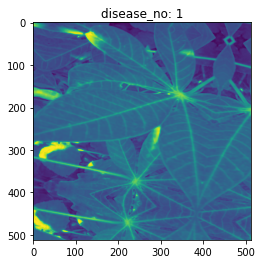

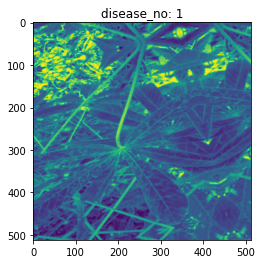

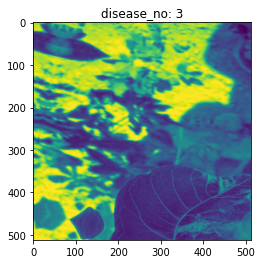

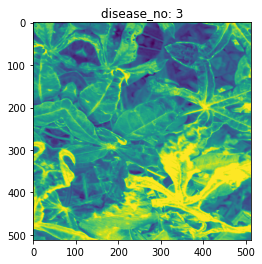

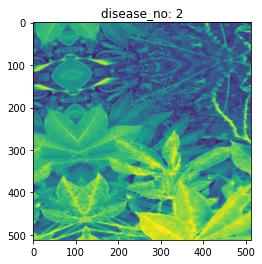

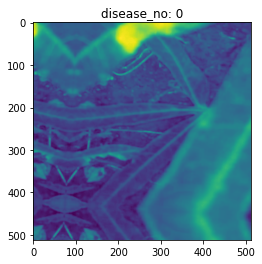

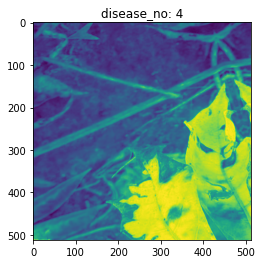

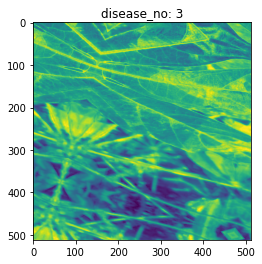

In [ ]:
cassava_train = Dataset_Train_Cassava(cassava_data, transform=cassava_augmentation(df='train'))

for index in range(10):
    cassava_img, disease_no = cassava_train[index]
    plt.imshow(cassava_img[0])
    plt.title(f'disease_no: {disease_no}')
    plt.show() 

# **6. Cassava EfficientNet Model**

In [ ]:
class Cassava_EfficientNet(nn.Module):
  def __init__(self, efficientnet='tf_efficientnet_b5_ns', pretrained=False):
    super().__init__()
    self.efficientnet = timm.create_model(efficientnet, pretrained=pretrained)
    efficientnet_in_features = self.efficientnet.classifier.in_features
    self.efficientnet.classifier = nn.Linear(efficientnet_in_features, CASSAVA.number_of_labels)

  def forward(self, input):
    input = self.efficientnet(input)
    return input

In [ ]:
efficientnet = Cassava_EfficientNet(efficientnet=CASSAVA.cv_model, pretrained=False)
efficientnet_train = Dataset_Train_Cassava(cassava_data, transform=cassava_augmentation(df='train'))
efficientnet_loader = DataLoader(efficientnet_train, batch_size=4, shuffle=True,
                          num_workers=4, pin_memory=True, drop_last=True)

for img, disease_no in efficientnet_loader:
  efficientnet_img = efficientnet(img)
  print(efficientnet_img.shape)
  print(efficientnet)
  break

torch.Size([4, 5])
Cassava_EfficientNet(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
          (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=0.001, 

# **7. Cassava Train and Test Support Functions**

In [ ]:
#Computes and stores the average and current value
class CassavaStats(object):
  def __init__(self):
    self.restart()

  def restart(self):
    self.value = 0
    self.average = 0
    self.total = 0
    self.number = 0

  def update(self, value, number=1):
    self.value = value
    self.total += value * number
    self.number += number
    self.average = self.total / self.number


def sec_to_min(sec):
  min = math.floor(sec / 60)
  sec -= min * 60
  return '%dm' %min 

def LapsedTime(begin, division):
    current = time.time()
    lapse = current - begin
    lapse_es = lapse / (division)
    lapse_rs = lapse_es - lapse
    return '%s (Left:%s)' % (sec_to_min(lapse), sec_to_min(lapse_rs))

In [ ]:
def efficientnet_tr(cassava_tr_iterable, efficientnet, efficientnet_entropy_loss, efficientnet_opt, efficientnet_epoch, efficientnet_sch, cuda):

  stats_batch = CassavaStats()
  stats_time = CassavaStats()
  stats_loss = CassavaStats()
  stats_scores = CassavaStats()

  # switch to train mode
  efficientnet.train()
  begin = finish = time.time()
  count = 0

  for number, (cassava_img, disease_no) in enumerate(cassava_tr_iterable):

    #print("finish:",finish)
    #print("time.time():",time.time())
    cassava_img = cassava_img.to(cuda)
    disease_no = disease_no.to(cuda)
    batch_size = disease_no.size(0)
    disease_forecast = efficientnet(cassava_img)
    cassava_entropy_loss = efficientnet_entropy_loss(disease_forecast, disease_no)

    # record loss
    stats_loss.update(cassava_entropy_loss.item(), batch_size)
    cassava_entropy_loss.backward()
    gradient_clip = torch.nn.utils.clip_grad_norm_(efficientnet.parameters(), CASSAVA.maximum_gradient)

    efficientnet_opt.step()
    efficientnet_opt.zero_grad()
    count += 1    

    if number % CASSAVA.freq_print == 0 or number == (len(cassava_tr_iterable)-1):
      time_elapsed = round((time.time() - finish)/60,2)
      stats_time.update(time_elapsed)
      finish = time.time() 
      print('Epoch:[{0}][{1}/{2}]  '
            'Time:{stats_time.value} min  '
            'Lapsed:{left:s}  '
            'Loss:{stats_loss.value:.3f}  '
            'Gradient:{gradient_clip:.3f}  '
            .format(
              efficientnet_epoch+1, number, len(cassava_tr_iterable),
              stats_time=stats_time,
              left=LapsedTime(begin, float(number+1)/len(cassava_tr_iterable)),
              stats_loss=stats_loss, gradient_clip=gradient_clip,
              ))
  return stats_loss.average


def efficientnet_val(cassava_val_iterable, efficientnet, efficientnet_entropy_loss, cuda):

  stats_batch = CassavaStats()
  stats_time = CassavaStats()
  stats_loss = CassavaStats()
  stats_scores = CassavaStats()

  # switch to evaluation mode
  efficientnet.eval()
  forecast = []
  begin = finish = time.time()
  for number, (cassava_img, disease_no) in enumerate(cassava_val_iterable):
    cassava_img = cassava_img.to(cuda)
    disease_no = disease_no.to(cuda)
    batch_size = disease_no.size(0)

    # compute loss
    with torch.no_grad():
        disease_forecast = efficientnet(cassava_img)
    cassava_entropy_loss = efficientnet_entropy_loss(disease_forecast, disease_no)
    stats_loss.update(cassava_entropy_loss.item(), batch_size)

    # record accuracy
    forecast.append(disease_forecast.softmax(1).to('cpu').numpy())

    if number % CASSAVA.freq_print == 0 or number == (len(cassava_val_iterable)-1):
      time_elapsed = round((time.time() - finish)/60,2)
      stats_time.update(time_elapsed)
      finish = time.time()
      print('EVAL:[{0}/{1}]  '
            'Time:{stats_time.value} min  '
            'Lapsed:{left:s}  '
            'Loss:{stats_loss.value:.3f}  '
            .format(
              number, len(cassava_val_iterable), 
              stats_time=stats_time,
              left=LapsedTime(begin, float(number+1)/len(cassava_val_iterable)),
              stats_loss=stats_loss,
              ))
  predictions = np.concatenate(forecast)
  return stats_loss.average, predictions


def efficientnet_inf(efficientnet, cassava_model_load, cassava_test_iterable, cuda):
  efficientnet.to(cuda)
  tqdm_test = tqdm(enumerate(cassava_test_iterable), total=len(cassava_test_iterable))
  cassava_probability = []
  for index, (cassava_img) in tqdm_test:
    cassava_img = cassava_img.to(cuda)
    average_forecast = []
    for model_state in cassava_model_load:
        efficientnet.load_state_dict(model_state['model'])
        efficientnet.eval()
        with torch.no_grad():
            disease_forecast = efficientnet(cassava_img)
        average_forecast.append(disease_forecast.softmax(1).to('cpu').numpy())
    average_forecast = np.mean(average_forecast, axis=0)
    cassava_probability.append(average_forecast)
  cassava_probability = np.concatenate(cassava_probability)
  return cassava_probability

# **8. Main Function**

In [ ]:
def main_tr(cassava_data_kfolds, kfold):

  CASSAVA_LOG.info(f"========== kfold: {kfold} training ==========")

  #loader
  train_index = cassava_data_kfolds[cassava_data_kfolds['fold'] != kfold].index
  validation_index = cassava_data_kfolds[cassava_data_kfolds['fold'] == kfold].index

  kfolds_tr = cassava_data_kfolds.loc[train_index].reset_index(drop=True)
  kfolds_val = cassava_data_kfolds.loc[validation_index].reset_index(drop=True)
    
  cassava_train = Dataset_Train_Cassava(kfolds_tr,transform=cassava_augmentation(df='train'))
  cassava_val = Dataset_Train_Cassava(kfolds_val,transform=cassava_augmentation(df='valid'))

  cassava_tr_iterable = DataLoader(cassava_train, 
                              batch_size=CASSAVA.data_batch, 
                              shuffle=True, 
                              num_workers=CASSAVA.cpu, pin_memory=True, drop_last=True)
  cassava_val_iterable = DataLoader(cassava_val, 
                              batch_size=CASSAVA.data_batch, 
                              shuffle=False, 
                              num_workers=CASSAVA.cpu, pin_memory=True, drop_last=False)


  # model, optimizer & scheduler
  efficientnet = Cassava_EfficientNet(CASSAVA.cv_model, pretrained=True)
  efficientnet.to(cuda)
  efficientnet_opt = Adam(efficientnet.parameters(), lr=CASSAVA.learning_rate, weight_decay=CASSAVA.wd, amsgrad=False)
  efficientnet_sch = CosineAnnealingWarmRestarts(efficientnet_opt, T_0=CASSAVA.cosine_annealing, T_mult=1, eta_min=CASSAVA.min_learning_rate, last_epoch=-1)

  # loop
  efficientnet_entropy_loss = nn.CrossEntropyLoss()
  top_scr = 0.
    
  for efficientnet_epoch in range(CASSAVA.no_epc):
        
    begin = time.time()
         
    # train
    average_tr_loss = efficientnet_tr(cassava_tr_iterable, efficientnet, efficientnet_entropy_loss, efficientnet_opt, efficientnet_epoch, efficientnet_sch, cuda)

    # eval
    average_val_loss, forecast = efficientnet_val(cassava_val_iterable, efficientnet, efficientnet_entropy_loss, cuda)
    disease_number = kfolds_val[CASSAVA.label_column].values
        
    efficientnet_sch.step()

    # scoring
    scr = cassava_scr(disease_number, forecast.argmax(1))

    lapse = time.time() - begin

    CASSAVA_LOG.info(f'Epoch {efficientnet_epoch+1} - average_tr_loss: {average_tr_loss:.4f}  average_val_loss: {average_val_loss:.4f}  time: {lapse:.0f}s')
    CASSAVA_LOG.info(f'Epoch {efficientnet_epoch+1} - Accuracy: {scr}')

    if scr > top_scr:
        top_scr = scr
        CASSAVA_LOG.info(f'Epoch {efficientnet_epoch+1} - Save Top Score: {top_scr:.4f} Model')
        torch.save({'efficientnet': efficientnet.state_dict(), 
                    'forecast': forecast},
                    OUTPUT_DIR+f'{CASSAVA.cv_model}_kfold{kfold}_best.pth')

  return kfolds_val

In [ ]:
# main
def main():

  if CASSAVA.tr:
    # train 
    out_of_fold = pd.DataFrame()
       
    for kfold in range(CASSAVA.kfold_no):
      if kfold in CASSAVA.kfold:
        _out_of_fold = main_tr(cassava_data_kfolds, kfold)
        CASSAVA_LOG.info(f"========== kfold: {kfold} result ==========")
                
    # CV result
    CASSAVA_LOG.info(f"========== CV ==========")
    
  if CASSAVA.inf:
    # inference
    efficientnet = Cassava_EfficientNet(CASSAVA.cv_model, pretrained=False)
    cassava_model_load = [torch.load(OUTPUT_DIR+f'{CASSAVA.cv_model}_kfold{kfold}_best.pth') for kfold in CASSAVA.kfold]
    cassava_test_dataset = Dataset_Test_Cassava(cassava_test, transform=cassava_augmentation(df='valid'))
    cassava_test_iterable = DataLoader(cassava_test_dataset, batch_size=CASSAVA.data_batch, shuffle=False, 
                                 num_workers=CASSAVA.cpu, pin_memory=True)
    forecast = efficientnet_inf(efficientnet, cassava_model_load, cassava_test_iterable, cuda)
    # submission
    cassava_test['label'] = forecast.argmax(1)
    cassava_test[['image_id', 'label']].to_csv(OUTPUT_DIR+'submission.csv', index=False)

In [ ]:
if __name__ == '__main__':
    main()

========== kfold: 0 training ==========
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b5_ns-6f26d0cf.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b5_ns-6f26d0cf.pth


Epoch:[1][0/2139]  Time:0.1 min  Lapsed:0m (Left:205m)  Loss:1.573  Gradient:3.544  
Epoch:[1][100/2139]  Time:1.68 min  Lapsed:1m (Left:35m)  Loss:0.548  Gradient:2.979  
Epoch:[1][200/2139]  Time:1.74 min  Lapsed:3m (Left:33m)  Loss:1.085  Gradient:5.745  
Epoch:[1][300/2139]  Time:1.64 min  Lapsed:5m (Left:31m)  Loss:0.735  Gradient:4.431  
Epoch:[1][400/2139]  Time:1.71 min  Lapsed:6m (Left:29m)  Loss:0.426  Gradient:3.662  
Epoch:[1][500/2139]  Time:1.63 min  Lapsed:8m (Left:27m)  Loss:0.334  Gradient:3.336  
Epoch:[1][600/2139]  Time:1.63 min  Lapsed:10m (Left:25m)  Loss:0.373  Gradient:3.248  
Epoch:[1][700/2139]  Time:1.64 min  Lapsed:11m (Left:24m)  Loss:0.337  Gradient:4.154  
Epoch:[1][800/2139]  Time:1.69 min  Lapsed:13m (Left:22m)  Loss:0.751  Gradient:2.951  
Epoch:[1][900/2139]  Time:1.6 min  Lapsed:15m (Left:20m)  Loss:0.416  Gradient:2.866  
Epoch:[1][1000/2139]  Time:1.65 min  Lapsed:16m (Left:18m)  Loss:0.536  Gradient:4.312  
Epoch:[1][1100/2139]  Time:1.65 min  Lap

Epoch 1 - average_tr_loss: 0.5769  average_val_loss: 0.4019  time: 2689s
Epoch 1 - Accuracy: 0.8619158878504672
Epoch 1 - Save Top Score: 0.8619 Model


EVAL:[534/535]  Time:0.59 min  Lapsed:9m (Left:0m)  Loss:0.438  
Epoch:[2][0/2139]  Time:0.02 min  Lapsed:0m (Left:40m)  Loss:0.226  Gradient:2.167  
Epoch:[2][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.360  Gradient:2.019  
Epoch:[2][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.174  Gradient:1.922  
Epoch:[2][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.239  Gradient:1.947  
Epoch:[2][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.126  Gradient:1.289  
Epoch:[2][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.168  Gradient:1.625  
Epoch:[2][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.205  Gradient:2.493  
Epoch:[2][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.289  Gradient:3.209  
Epoch:[2][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.398  Gradient:3.089  
Epoch:[2][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.820  Gradient:5.436  
Epoch:[2][1000/2139]  Time:0.9 min  Lapsed:8m (Left:10m)  Loss:0.108  Gradie

Epoch 2 - average_tr_loss: 0.4479  average_val_loss: 0.3728  time: 1220s
Epoch 2 - Accuracy: 0.8792056074766356
Epoch 2 - Save Top Score: 0.8792 Model


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.592  
Epoch:[3][0/2139]  Time:0.02 min  Lapsed:0m (Left:41m)  Loss:0.569  Gradient:2.477  
Epoch:[3][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.403  Gradient:3.140  
Epoch:[3][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.343  Gradient:2.683  
Epoch:[3][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.588  Gradient:5.462  
Epoch:[3][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.589  Gradient:3.511  
Epoch:[3][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.742  Gradient:3.082  
Epoch:[3][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.592  Gradient:3.310  
Epoch:[3][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.671  Gradient:3.752  
Epoch:[3][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.421  Gradient:3.208  
Epoch:[3][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.505  Gradient:3.119  
Epoch:[3][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.318  Gradie

Epoch 3 - average_tr_loss: 0.4080  average_val_loss: 0.3448  time: 1220s
Epoch 3 - Accuracy: 0.8894859813084112
Epoch 3 - Save Top Score: 0.8895 Model


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.680  
Epoch:[4][0/2139]  Time:0.02 min  Lapsed:0m (Left:41m)  Loss:0.358  Gradient:2.356  
Epoch:[4][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.503  Gradient:4.227  
Epoch:[4][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.429  Gradient:4.038  
Epoch:[4][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.152  Gradient:1.746  
Epoch:[4][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.104  Gradient:1.851  
Epoch:[4][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.020  Gradient:0.182  
Epoch:[4][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.282  Gradient:2.874  
Epoch:[4][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.518  Gradient:3.020  
Epoch:[4][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.777  Gradient:3.395  
Epoch:[4][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.605  Gradient:3.873  
Epoch:[4][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.510  Gradie

Epoch 4 - average_tr_loss: 0.3813  average_val_loss: 0.3485  time: 1221s
Epoch 4 - Accuracy: 0.8848130841121495


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.824  
Epoch:[5][0/2139]  Time:0.02 min  Lapsed:0m (Left:40m)  Loss:0.059  Gradient:0.882  
Epoch:[5][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.368  Gradient:3.314  
Epoch:[5][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.212  Gradient:2.730  
Epoch:[5][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.064  Gradient:0.955  
Epoch:[5][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.490  Gradient:3.382  
Epoch:[5][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.045  Gradient:0.541  
Epoch:[5][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.082  Gradient:1.185  
Epoch:[5][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.514  Gradient:2.906  
Epoch:[5][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.696  Gradient:3.682  
Epoch:[5][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.074  Gradient:0.906  
Epoch:[5][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.441  Gradie

Epoch 5 - average_tr_loss: 0.3550  average_val_loss: 0.3550  time: 1221s
Epoch 5 - Accuracy: 0.8803738317757009


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.413  
Epoch:[6][0/2139]  Time:0.02 min  Lapsed:0m (Left:41m)  Loss:0.239  Gradient:1.944  
Epoch:[6][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.457  Gradient:2.844  
Epoch:[6][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.061  Gradient:0.932  
Epoch:[6][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.064  Gradient:0.928  
Epoch:[6][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.273  Gradient:3.712  
Epoch:[6][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.384  Gradient:4.134  
Epoch:[6][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.909  Gradient:4.466  
Epoch:[6][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.101  Gradient:1.097  
Epoch:[6][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.885  Gradient:5.110  
Epoch:[6][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.621  Gradient:4.183  
Epoch:[6][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.443  Gradie

Epoch 6 - average_tr_loss: 0.3260  average_val_loss: 0.3262  time: 1221s
Epoch 6 - Accuracy: 0.8953271028037383
Epoch 6 - Save Top Score: 0.8953 Model


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.870  
Epoch:[7][0/2139]  Time:0.02 min  Lapsed:0m (Left:41m)  Loss:0.319  Gradient:2.881  
Epoch:[7][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.072  Gradient:0.900  
Epoch:[7][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.115  Gradient:1.288  
Epoch:[7][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.230  Gradient:2.314  
Epoch:[7][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.427  Gradient:4.503  
Epoch:[7][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.295  Gradient:3.190  
Epoch:[7][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.314  Gradient:2.978  
Epoch:[7][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.093  Gradient:1.368  
Epoch:[7][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.706  Gradient:4.628  
Epoch:[7][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.341  Gradient:3.266  
Epoch:[7][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.373  Gradie

Epoch 7 - average_tr_loss: 0.3014  average_val_loss: 0.3385  time: 1221s
Epoch 7 - Accuracy: 0.8922897196261682


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.419  
Epoch:[8][0/2139]  Time:0.02 min  Lapsed:0m (Left:41m)  Loss:0.189  Gradient:2.991  
Epoch:[8][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.153  Gradient:1.832  
Epoch:[8][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.327  Gradient:1.932  
Epoch:[8][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.249  Gradient:2.705  
Epoch:[8][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.863  Gradient:5.637  
Epoch:[8][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.062  Gradient:0.711  
Epoch:[8][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.363  Gradient:3.570  
Epoch:[8][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.068  Gradient:1.278  
Epoch:[8][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.169  Gradient:3.723  
Epoch:[8][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.579  Gradient:5.523  
Epoch:[8][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.390  Gradie

Epoch 8 - average_tr_loss: 0.2837  average_val_loss: 0.3611  time: 1221s
Epoch 8 - Accuracy: 0.8880841121495328


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.612  
Epoch:[9][0/2139]  Time:0.02 min  Lapsed:0m (Left:42m)  Loss:0.506  Gradient:4.512  
Epoch:[9][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.482  Gradient:2.669  
Epoch:[9][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.812  Gradient:5.043  
Epoch:[9][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.164  Gradient:2.068  
Epoch:[9][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.381  Gradient:5.035  
Epoch:[9][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.099  Gradient:1.718  
Epoch:[9][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.466  Gradient:4.357  
Epoch:[9][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.204  Gradient:3.649  
Epoch:[9][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.009  Gradient:0.102  
Epoch:[9][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.440  Gradient:3.854  
Epoch:[9][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.226  Gradie

Epoch 9 - average_tr_loss: 0.2651  average_val_loss: 0.3492  time: 1221s
Epoch 9 - Accuracy: 0.8883177570093458


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.484  
Epoch:[10][0/2139]  Time:0.02 min  Lapsed:0m (Left:41m)  Loss:0.106  Gradient:1.829  
Epoch:[10][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.022  Gradient:0.308  
Epoch:[10][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.013  Gradient:0.175  
Epoch:[10][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.402  Gradient:4.093  
Epoch:[10][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.179  Gradient:4.202  
Epoch:[10][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.114  Gradient:2.413  
Epoch:[10][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.062  Gradient:0.906  
Epoch:[10][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.023  Gradient:0.360  
Epoch:[10][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.357  Gradient:4.599  
Epoch:[10][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.037  Gradient:0.834  
Epoch:[10][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.

Epoch 10 - average_tr_loss: 0.2569  average_val_loss: 0.3485  time: 1222s
Epoch 10 - Accuracy: 0.8899532710280373
========== kfold: 0 result ==========
========== kfold: 1 training ==========


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.523  
Epoch:[1][0/2139]  Time:0.02 min  Lapsed:0m (Left:42m)  Loss:1.582  Gradient:3.387  
Epoch:[1][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.724  Gradient:3.713  
Epoch:[1][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.847  Gradient:4.642  
Epoch:[1][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.644  Gradient:3.820  
Epoch:[1][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.539  Gradient:4.752  
Epoch:[1][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.646  Gradient:5.309  
Epoch:[1][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.739  Gradient:5.201  
Epoch:[1][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.285  Gradient:2.533  
Epoch:[1][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.642  Gradient:4.251  
Epoch:[1][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.874  Gradient:4.067  
Epoch:[1][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.378  Gradie

Epoch 1 - average_tr_loss: 0.5842  average_val_loss: 0.3678  time: 1222s
Epoch 1 - Accuracy: 0.8792056074766356
Epoch 1 - Save Top Score: 0.8792 Model


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.199  
Epoch:[2][0/2139]  Time:0.02 min  Lapsed:0m (Left:41m)  Loss:0.863  Gradient:4.193  
Epoch:[2][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.210  Gradient:2.304  
Epoch:[2][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.239  Gradient:2.952  
Epoch:[2][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.532  Gradient:3.057  
Epoch:[2][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.521  Gradient:2.550  
Epoch:[2][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.487  Gradient:4.430  
Epoch:[2][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.600  Gradient:3.791  
Epoch:[2][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.708  Gradient:2.751  
Epoch:[2][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:1.533  Gradient:8.429  
Epoch:[2][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.176  Gradient:3.389  
Epoch:[2][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.595  Gradie

Epoch 2 - average_tr_loss: 0.4498  average_val_loss: 0.3392  time: 1222s
Epoch 2 - Accuracy: 0.8824766355140187
Epoch 2 - Save Top Score: 0.8825 Model


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.042  
Epoch:[3][0/2139]  Time:0.02 min  Lapsed:0m (Left:44m)  Loss:0.234  Gradient:2.147  
Epoch:[3][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.691  Gradient:4.217  
Epoch:[3][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.583  Gradient:3.729  
Epoch:[3][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.617  Gradient:4.292  
Epoch:[3][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.068  Gradient:0.650  
Epoch:[3][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.329  Gradient:2.550  
Epoch:[3][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:1.105  Gradient:5.176  
Epoch:[3][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.187  Gradient:2.081  
Epoch:[3][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.422  Gradient:4.674  
Epoch:[3][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.764  Gradient:2.870  
Epoch:[3][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.155  Gradie

Epoch 3 - average_tr_loss: 0.4218  average_val_loss: 0.3483  time: 1222s
Epoch 3 - Accuracy: 0.8822429906542056


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.077  
Epoch:[4][0/2139]  Time:0.02 min  Lapsed:0m (Left:43m)  Loss:0.155  Gradient:1.695  
Epoch:[4][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.556  Gradient:3.038  
Epoch:[4][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.044  Gradient:0.686  
Epoch:[4][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.671  Gradient:4.063  
Epoch:[4][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.365  Gradient:4.465  
Epoch:[4][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.289  Gradient:2.496  
Epoch:[4][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.389  Gradient:2.674  
Epoch:[4][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.728  Gradient:4.092  
Epoch:[4][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.747  Gradient:4.135  
Epoch:[4][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.233  Gradient:2.153  
Epoch:[4][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.035  Gradie

Epoch 4 - average_tr_loss: 0.3816  average_val_loss: 0.3419  time: 1223s
Epoch 4 - Accuracy: 0.8841121495327103
Epoch 4 - Save Top Score: 0.8841 Model


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.122  
Epoch:[5][0/2139]  Time:0.02 min  Lapsed:0m (Left:41m)  Loss:0.042  Gradient:0.544  
Epoch:[5][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.264  Gradient:2.481  
Epoch:[5][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.723  Gradient:4.025  
Epoch:[5][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.243  Gradient:2.709  
Epoch:[5][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.161  Gradient:3.393  
Epoch:[5][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.315  Gradient:3.383  
Epoch:[5][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.523  Gradient:4.105  
Epoch:[5][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.378  Gradient:3.408  
Epoch:[5][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.358  Gradient:2.591  
Epoch:[5][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.130  Gradient:1.877  
Epoch:[5][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.170  Gradie

Epoch 5 - average_tr_loss: 0.3584  average_val_loss: 0.3528  time: 1223s
Epoch 5 - Accuracy: 0.8911214953271028
Epoch 5 - Save Top Score: 0.8911 Model


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.098  
Epoch:[6][0/2139]  Time:0.02 min  Lapsed:0m (Left:43m)  Loss:0.179  Gradient:2.187  
Epoch:[6][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.530  Gradient:3.772  
Epoch:[6][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.153  Gradient:2.624  
Epoch:[6][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.482  Gradient:4.734  
Epoch:[6][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.511  Gradient:3.419  
Epoch:[6][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.124  Gradient:1.458  
Epoch:[6][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.334  Gradient:2.887  
Epoch:[6][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.154  Gradient:3.194  
Epoch:[6][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.726  Gradient:4.094  
Epoch:[6][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.094  Gradient:1.186  
Epoch:[6][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.354  Gradie

Epoch 6 - average_tr_loss: 0.3270  average_val_loss: 0.3434  time: 1223s
Epoch 6 - Accuracy: 0.8864485981308411


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.055  
Epoch:[7][0/2139]  Time:0.02 min  Lapsed:0m (Left:42m)  Loss:0.056  Gradient:0.688  
Epoch:[7][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.217  Gradient:3.226  
Epoch:[7][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.023  Gradient:0.375  
Epoch:[7][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.520  Gradient:3.133  
Epoch:[7][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.285  Gradient:2.505  
Epoch:[7][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.385  Gradient:4.219  
Epoch:[7][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.890  Gradient:6.622  
Epoch:[7][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.020  Gradient:0.322  
Epoch:[7][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.362  Gradient:5.034  
Epoch:[7][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.369  Gradient:3.438  
Epoch:[7][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.045  Gradie

Epoch 7 - average_tr_loss: 0.3098  average_val_loss: 0.3232  time: 1223s
Epoch 7 - Accuracy: 0.8943925233644859
Epoch 7 - Save Top Score: 0.8944 Model


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.051  
Epoch:[8][0/2139]  Time:0.02 min  Lapsed:0m (Left:41m)  Loss:0.114  Gradient:1.672  
Epoch:[8][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.739  Gradient:4.142  
Epoch:[8][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.149  Gradient:2.261  
Epoch:[8][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.209  Gradient:2.808  
Epoch:[8][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.412  Gradient:4.528  
Epoch:[8][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.293  Gradient:3.862  
Epoch:[8][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.178  Gradient:3.443  
Epoch:[8][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.281  Gradient:3.104  
Epoch:[8][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.398  Gradient:4.791  
Epoch:[8][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.454  Gradient:4.495  
Epoch:[8][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.472  Gradie

Epoch 8 - average_tr_loss: 0.2982  average_val_loss: 0.4059  time: 1223s
Epoch 8 - Accuracy: 0.8941588785046729


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.017  
Epoch:[9][0/2139]  Time:0.02 min  Lapsed:0m (Left:43m)  Loss:0.406  Gradient:4.606  
Epoch:[9][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.466  Gradient:3.637  
Epoch:[9][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.098  Gradient:1.622  
Epoch:[9][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.086  Gradient:1.388  
Epoch:[9][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.262  Gradient:3.004  
Epoch:[9][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.172  Gradient:2.468  
Epoch:[9][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.092  Gradient:1.577  
Epoch:[9][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.536  Gradient:5.130  
Epoch:[9][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.584  Gradient:4.837  
Epoch:[9][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.144  Gradient:2.817  
Epoch:[9][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.118  Gradie

Epoch 9 - average_tr_loss: 0.2727  average_val_loss: 0.3820  time: 1222s
Epoch 9 - Accuracy: 0.8920560747663552


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.024  
Epoch:[10][0/2139]  Time:0.02 min  Lapsed:0m (Left:41m)  Loss:0.526  Gradient:7.635  
Epoch:[10][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.453  Gradient:3.622  
Epoch:[10][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.112  Gradient:1.672  
Epoch:[10][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.331  Gradient:4.510  
Epoch:[10][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.078  Gradient:1.566  
Epoch:[10][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.298  Gradient:3.445  
Epoch:[10][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.654  Gradient:6.493  
Epoch:[10][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.075  Gradient:1.366  
Epoch:[10][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.059  Gradient:0.957  
Epoch:[10][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.101  Gradient:1.784  
Epoch:[10][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.

Epoch 10 - average_tr_loss: 0.2563  average_val_loss: 0.4785  time: 1223s
Epoch 10 - Accuracy: 0.8932242990654206
========== kfold: 1 result ==========
========== kfold: 2 training ==========


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.024  
Epoch:[1][0/2139]  Time:0.02 min  Lapsed:0m (Left:41m)  Loss:1.607  Gradient:4.020  
Epoch:[1][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.702  Gradient:3.065  
Epoch:[1][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.617  Gradient:3.971  
Epoch:[1][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.460  Gradient:4.111  
Epoch:[1][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:1.276  Gradient:6.242  
Epoch:[1][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:1.017  Gradient:5.669  
Epoch:[1][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.348  Gradient:2.479  
Epoch:[1][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.159  Gradient:1.784  
Epoch:[1][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.467  Gradient:4.339  
Epoch:[1][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.205  Gradient:1.796  
Epoch:[1][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:1.435  Gradie

Epoch 1 - average_tr_loss: 0.5760  average_val_loss: 0.3787  time: 1223s
Epoch 1 - Accuracy: 0.8695956999298902
Epoch 1 - Save Top Score: 0.8696 Model


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.138  
Epoch:[2][0/2139]  Time:0.02 min  Lapsed:0m (Left:41m)  Loss:0.561  Gradient:4.308  
Epoch:[2][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.555  Gradient:3.427  
Epoch:[2][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.512  Gradient:2.619  
Epoch:[2][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.411  Gradient:3.427  
Epoch:[2][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.111  Gradient:1.231  
Epoch:[2][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.456  Gradient:3.479  
Epoch:[2][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.409  Gradient:2.184  
Epoch:[2][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.310  Gradient:3.037  
Epoch:[2][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.343  Gradient:2.030  
Epoch:[2][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.720  Gradient:4.730  
Epoch:[2][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.259  Gradie

Epoch 2 - average_tr_loss: 0.4538  average_val_loss: 0.3709  time: 1223s
Epoch 2 - Accuracy: 0.8698293993923814
Epoch 2 - Save Top Score: 0.8698 Model


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.233  
Epoch:[3][0/2139]  Time:0.02 min  Lapsed:0m (Left:42m)  Loss:0.111  Gradient:1.403  
Epoch:[3][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:1.033  Gradient:6.095  
Epoch:[3][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.396  Gradient:3.315  
Epoch:[3][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.399  Gradient:2.180  
Epoch:[3][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:1.164  Gradient:4.726  
Epoch:[3][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.479  Gradient:2.396  
Epoch:[3][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.284  Gradient:3.240  
Epoch:[3][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.616  Gradient:2.705  
Epoch:[3][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.523  Gradient:3.331  
Epoch:[3][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.687  Gradient:3.938  
Epoch:[3][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.179  Gradie

Epoch 3 - average_tr_loss: 0.4104  average_val_loss: 0.3843  time: 1223s
Epoch 3 - Accuracy: 0.8808132741294695
Epoch 3 - Save Top Score: 0.8808 Model


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.096  
Epoch:[4][0/2139]  Time:0.02 min  Lapsed:0m (Left:41m)  Loss:0.252  Gradient:1.922  
Epoch:[4][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.910  Gradient:5.279  
Epoch:[4][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.560  Gradient:5.365  
Epoch:[4][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.254  Gradient:2.251  
Epoch:[4][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:1.429  Gradient:6.699  
Epoch:[4][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.023  Gradient:0.270  
Epoch:[4][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.562  Gradient:3.532  
Epoch:[4][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.143  Gradient:1.221  
Epoch:[4][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.378  Gradient:4.261  
Epoch:[4][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.233  Gradient:1.875  
Epoch:[4][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.070  Gradie

Epoch 4 - average_tr_loss: 0.3769  average_val_loss: 0.3700  time: 1223s
Epoch 4 - Accuracy: 0.8759055854171536


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.112  
Epoch:[5][0/2139]  Time:0.02 min  Lapsed:0m (Left:42m)  Loss:0.051  Gradient:0.525  
Epoch:[5][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:1.320  Gradient:5.099  
Epoch:[5][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.056  Gradient:1.002  
Epoch:[5][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.065  Gradient:1.133  
Epoch:[5][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.927  Gradient:3.696  
Epoch:[5][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.566  Gradient:4.389  
Epoch:[5][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.145  Gradient:2.102  
Epoch:[5][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.259  Gradient:2.918  
Epoch:[5][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.252  Gradient:2.118  
Epoch:[5][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.232  Gradient:1.681  
Epoch:[5][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.147  Gradie

Epoch 5 - average_tr_loss: 0.3565  average_val_loss: 0.3445  time: 1223s
Epoch 5 - Accuracy: 0.8836176676793643
Epoch 5 - Save Top Score: 0.8836 Model


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.181  
Epoch:[6][0/2139]  Time:0.02 min  Lapsed:0m (Left:41m)  Loss:0.595  Gradient:4.210  
Epoch:[6][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.109  Gradient:1.693  
Epoch:[6][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.027  Gradient:0.364  
Epoch:[6][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.132  Gradient:1.297  
Epoch:[6][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.474  Gradient:4.128  
Epoch:[6][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.304  Gradient:2.584  
Epoch:[6][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.220  Gradient:2.997  
Epoch:[6][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.116  Gradient:1.662  
Epoch:[6][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.330  Gradient:4.765  
Epoch:[6][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.060  Gradient:0.623  
Epoch:[6][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.201  Gradie

Epoch 6 - average_tr_loss: 0.3315  average_val_loss: 0.3508  time: 1222s
Epoch 6 - Accuracy: 0.8819817714419257


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.172  
Epoch:[7][0/2139]  Time:0.02 min  Lapsed:0m (Left:40m)  Loss:0.096  Gradient:1.838  
Epoch:[7][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.120  Gradient:2.182  
Epoch:[7][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.398  Gradient:5.723  
Epoch:[7][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.284  Gradient:2.739  
Epoch:[7][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.110  Gradient:1.661  
Epoch:[7][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.142  Gradient:1.794  
Epoch:[7][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.656  Gradient:3.394  
Epoch:[7][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.336  Gradient:3.853  
Epoch:[7][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.025  Gradient:0.326  
Epoch:[7][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.123  Gradient:1.495  
Epoch:[7][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.617  Gradie

Epoch 7 - average_tr_loss: 0.3081  average_val_loss: 0.3360  time: 1222s
Epoch 7 - Accuracy: 0.8885253563916803
Epoch 7 - Save Top Score: 0.8885 Model


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.244  
Epoch:[8][0/2139]  Time:0.02 min  Lapsed:0m (Left:42m)  Loss:0.234  Gradient:2.775  
Epoch:[8][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.328  Gradient:4.018  
Epoch:[8][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.252  Gradient:3.384  
Epoch:[8][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.115  Gradient:1.291  
Epoch:[8][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.436  Gradient:4.467  
Epoch:[8][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.050  Gradient:0.859  
Epoch:[8][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.124  Gradient:1.547  
Epoch:[8][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.045  Gradient:0.818  
Epoch:[8][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.314  Gradient:4.308  
Epoch:[8][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.276  Gradient:4.010  
Epoch:[8][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.161  Gradie

Epoch 8 - average_tr_loss: 0.2888  average_val_loss: 0.3431  time: 1221s
Epoch 8 - Accuracy: 0.8899275531666277
Epoch 8 - Save Top Score: 0.8899 Model


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.171  
Epoch:[9][0/2139]  Time:0.02 min  Lapsed:0m (Left:42m)  Loss:0.807  Gradient:6.493  
Epoch:[9][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.103  Gradient:1.924  
Epoch:[9][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.467  Gradient:3.639  
Epoch:[9][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.229  Gradient:2.862  
Epoch:[9][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.101  Gradient:1.547  
Epoch:[9][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.080  Gradient:1.129  
Epoch:[9][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.603  Gradient:5.922  
Epoch:[9][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.302  Gradient:3.150  
Epoch:[9][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.710  Gradient:6.671  
Epoch:[9][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.048  Gradient:0.806  
Epoch:[9][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.030  Gradie

Epoch 9 - average_tr_loss: 0.2704  average_val_loss: 0.3352  time: 1222s
Epoch 9 - Accuracy: 0.8922645477915401
Epoch 9 - Save Top Score: 0.8923 Model


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.138  
Epoch:[10][0/2139]  Time:0.02 min  Lapsed:0m (Left:42m)  Loss:0.110  Gradient:1.858  
Epoch:[10][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.287  Gradient:2.337  
Epoch:[10][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.116  Gradient:1.902  
Epoch:[10][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.088  Gradient:1.505  
Epoch:[10][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.235  Gradient:5.369  
Epoch:[10][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.026  Gradient:0.736  
Epoch:[10][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.224  Gradient:3.534  
Epoch:[10][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.080  Gradient:1.337  
Epoch:[10][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.208  Gradient:3.865  
Epoch:[10][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.333  Gradient:4.054  
Epoch:[10][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.

Epoch 10 - average_tr_loss: 0.2637  average_val_loss: 0.3401  time: 1221s
Epoch 10 - Accuracy: 0.8896938537041365
========== kfold: 2 result ==========
========== kfold: 3 training ==========


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.143  
Epoch:[1][0/2139]  Time:0.02 min  Lapsed:0m (Left:42m)  Loss:1.583  Gradient:3.829  
Epoch:[1][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.874  Gradient:3.505  
Epoch:[1][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.721  Gradient:3.955  
Epoch:[1][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.490  Gradient:4.443  
Epoch:[1][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:1.226  Gradient:8.081  
Epoch:[1][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.859  Gradient:3.682  
Epoch:[1][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.509  Gradient:3.603  
Epoch:[1][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.456  Gradient:3.166  
Epoch:[1][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.218  Gradient:2.713  
Epoch:[1][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:1.131  Gradient:4.251  
Epoch:[1][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.486  Gradie

Epoch 1 - average_tr_loss: 0.5777  average_val_loss: 0.4099  time: 1221s
Epoch 1 - Accuracy: 0.8586118251928021
Epoch 1 - Save Top Score: 0.8586 Model


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.533  
Epoch:[2][0/2139]  Time:0.02 min  Lapsed:0m (Left:41m)  Loss:0.753  Gradient:3.478  
Epoch:[2][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.295  Gradient:2.160  
Epoch:[2][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.416  Gradient:4.184  
Epoch:[2][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.596  Gradient:3.703  
Epoch:[2][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.080  Gradient:1.163  
Epoch:[2][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.164  Gradient:1.940  
Epoch:[2][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:1.087  Gradient:5.945  
Epoch:[2][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.484  Gradient:2.313  
Epoch:[2][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.471  Gradient:3.531  
Epoch:[2][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.436  Gradient:3.555  
Epoch:[2][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.443  Gradie

Epoch 2 - average_tr_loss: 0.4526  average_val_loss: 0.4026  time: 1221s
Epoch 2 - Accuracy: 0.8600140219677495
Epoch 2 - Save Top Score: 0.8600 Model


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.468  
Epoch:[3][0/2139]  Time:0.02 min  Lapsed:0m (Left:44m)  Loss:0.177  Gradient:1.564  
Epoch:[3][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.694  Gradient:3.563  
Epoch:[3][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.469  Gradient:3.924  
Epoch:[3][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.072  Gradient:0.669  
Epoch:[3][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.123  Gradient:2.169  
Epoch:[3][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.163  Gradient:1.391  
Epoch:[3][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:1.084  Gradient:4.744  
Epoch:[3][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.426  Gradient:3.845  
Epoch:[3][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.485  Gradient:2.969  
Epoch:[3][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.638  Gradient:4.886  
Epoch:[3][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.196  Gradie

Epoch 3 - average_tr_loss: 0.4024  average_val_loss: 0.3973  time: 1221s
Epoch 3 - Accuracy: 0.8642206122925917
Epoch 3 - Save Top Score: 0.8642 Model


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.202  
Epoch:[4][0/2139]  Time:0.02 min  Lapsed:0m (Left:42m)  Loss:0.270  Gradient:3.447  
Epoch:[4][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.318  Gradient:4.455  
Epoch:[4][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.369  Gradient:2.499  
Epoch:[4][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.164  Gradient:2.669  
Epoch:[4][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.219  Gradient:2.937  
Epoch:[4][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.381  Gradient:2.454  
Epoch:[4][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.625  Gradient:3.970  
Epoch:[4][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.493  Gradient:5.362  
Epoch:[4][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.438  Gradient:4.410  
Epoch:[4][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.066  Gradient:1.314  
Epoch:[4][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.942  Gradie

Epoch 4 - average_tr_loss: 0.3773  average_val_loss: 0.3797  time: 1222s
Epoch 4 - Accuracy: 0.8794110773545221
Epoch 4 - Save Top Score: 0.8794 Model


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.327  
Epoch:[5][0/2139]  Time:0.02 min  Lapsed:0m (Left:42m)  Loss:0.352  Gradient:3.049  
Epoch:[5][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.499  Gradient:2.737  
Epoch:[5][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.239  Gradient:2.574  
Epoch:[5][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.349  Gradient:3.179  
Epoch:[5][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.710  Gradient:3.786  
Epoch:[5][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.304  Gradient:3.057  
Epoch:[5][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.039  Gradient:0.509  
Epoch:[5][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.439  Gradient:4.712  
Epoch:[5][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.113  Gradient:1.033  
Epoch:[5][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.040  Gradient:0.435  
Epoch:[5][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:1.293  Gradie

Epoch 5 - average_tr_loss: 0.3594  average_val_loss: 0.3776  time: 1222s
Epoch 5 - Accuracy: 0.8850198644543118
Epoch 5 - Save Top Score: 0.8850 Model


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.247  
Epoch:[6][0/2139]  Time:0.02 min  Lapsed:0m (Left:43m)  Loss:0.398  Gradient:5.274  
Epoch:[6][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.406  Gradient:5.037  
Epoch:[6][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.124  Gradient:2.528  
Epoch:[6][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.266  Gradient:3.570  
Epoch:[6][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.030  Gradient:0.602  
Epoch:[6][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.140  Gradient:1.749  
Epoch:[6][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.076  Gradient:1.137  
Epoch:[6][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.317  Gradient:4.416  
Epoch:[6][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.205  Gradient:2.580  
Epoch:[6][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.022  Gradient:0.332  
Epoch:[6][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.431  Gradie

Epoch 6 - average_tr_loss: 0.3270  average_val_loss: 0.3674  time: 1222s
Epoch 6 - Accuracy: 0.881280673054452


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.271  
Epoch:[7][0/2139]  Time:0.02 min  Lapsed:0m (Left:45m)  Loss:0.403  Gradient:3.519  
Epoch:[7][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.796  Gradient:5.834  
Epoch:[7][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.181  Gradient:2.103  
Epoch:[7][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.236  Gradient:3.152  
Epoch:[7][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.061  Gradient:0.983  
Epoch:[7][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.399  Gradient:3.203  
Epoch:[7][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.094  Gradient:2.175  
Epoch:[7][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.764  Gradient:4.070  
Epoch:[7][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.172  Gradient:1.789  
Epoch:[7][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.274  Gradient:2.243  
Epoch:[7][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.053  Gradie

Epoch 7 - average_tr_loss: 0.3083  average_val_loss: 0.3753  time: 1223s
Epoch 7 - Accuracy: 0.8836176676793643


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.245  
Epoch:[8][0/2139]  Time:0.02 min  Lapsed:0m (Left:41m)  Loss:0.192  Gradient:2.916  
Epoch:[8][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.593  Gradient:6.144  
Epoch:[8][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.501  Gradient:4.483  
Epoch:[8][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.321  Gradient:3.967  
Epoch:[8][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.369  Gradient:3.288  
Epoch:[8][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.021  Gradient:0.276  
Epoch:[8][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.204  Gradient:2.885  
Epoch:[8][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.199  Gradient:2.554  
Epoch:[8][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.240  Gradient:3.266  
Epoch:[8][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.215  Gradient:3.144  
Epoch:[8][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.161  Gradie

Epoch 8 - average_tr_loss: 0.2822  average_val_loss: 0.3610  time: 1222s
Epoch 8 - Accuracy: 0.8868894601542416
Epoch 8 - Save Top Score: 0.8869 Model


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.463  
Epoch:[9][0/2139]  Time:0.02 min  Lapsed:0m (Left:44m)  Loss:0.574  Gradient:5.521  
Epoch:[9][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.062  Gradient:1.166  
Epoch:[9][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.416  Gradient:4.437  
Epoch:[9][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:1.070  Gradient:4.555  
Epoch:[9][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.064  Gradient:1.116  
Epoch:[9][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.140  Gradient:2.868  
Epoch:[9][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.042  Gradient:0.826  
Epoch:[9][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.337  Gradient:4.987  
Epoch:[9][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.013  Gradient:0.169  
Epoch:[9][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.194  Gradient:2.706  
Epoch:[9][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.096  Gradie

Epoch 9 - average_tr_loss: 0.2693  average_val_loss: 0.3736  time: 1224s
Epoch 9 - Accuracy: 0.8880579574666978
Epoch 9 - Save Top Score: 0.8881 Model


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.302  
Epoch:[10][0/2139]  Time:0.02 min  Lapsed:0m (Left:45m)  Loss:0.298  Gradient:4.297  
Epoch:[10][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.146  Gradient:1.864  
Epoch:[10][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.050  Gradient:1.593  
Epoch:[10][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.176  Gradient:2.934  
Epoch:[10][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.253  Gradient:3.363  
Epoch:[10][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.040  Gradient:0.658  
Epoch:[10][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.146  Gradient:1.603  
Epoch:[10][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.068  Gradient:1.779  
Epoch:[10][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.093  Gradient:1.721  
Epoch:[10][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.154  Gradient:2.757  
Epoch:[10][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.

Epoch 10 - average_tr_loss: 0.2526  average_val_loss: 0.3670  time: 1223s
Epoch 10 - Accuracy: 0.8868894601542416
========== kfold: 3 result ==========
========== kfold: 4 training ==========


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.313  
Epoch:[1][0/2139]  Time:0.02 min  Lapsed:0m (Left:45m)  Loss:1.608  Gradient:3.084  
Epoch:[1][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.628  Gradient:3.723  
Epoch:[1][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:1.427  Gradient:7.049  
Epoch:[1][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.559  Gradient:4.259  
Epoch:[1][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.614  Gradient:4.595  
Epoch:[1][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.688  Gradient:4.399  
Epoch:[1][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.396  Gradient:3.111  
Epoch:[1][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.136  Gradient:1.495  
Epoch:[1][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.596  Gradient:4.074  
Epoch:[1][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.272  Gradient:2.541  
Epoch:[1][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.347  Gradie

Epoch 1 - average_tr_loss: 0.5835  average_val_loss: 0.3969  time: 1222s
Epoch 1 - Accuracy: 0.8597803225052583
Epoch 1 - Save Top Score: 0.8598 Model


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.638  
Epoch:[2][0/2139]  Time:0.02 min  Lapsed:0m (Left:41m)  Loss:0.635  Gradient:3.995  
Epoch:[2][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.489  Gradient:3.778  
Epoch:[2][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.322  Gradient:4.151  
Epoch:[2][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.437  Gradient:4.066  
Epoch:[2][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.211  Gradient:1.582  
Epoch:[2][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.298  Gradient:3.323  
Epoch:[2][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.244  Gradient:2.056  
Epoch:[2][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.484  Gradient:3.646  
Epoch:[2][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.204  Gradient:1.600  
Epoch:[2][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.154  Gradient:1.654  
Epoch:[2][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.333  Gradie

Epoch 2 - average_tr_loss: 0.4506  average_val_loss: 0.4167  time: 1222s
Epoch 2 - Accuracy: 0.8616499182051881
Epoch 2 - Save Top Score: 0.8616 Model


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.782  
Epoch:[3][0/2139]  Time:0.02 min  Lapsed:0m (Left:43m)  Loss:0.246  Gradient:2.208  
Epoch:[3][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.583  Gradient:3.044  
Epoch:[3][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.080  Gradient:1.399  
Epoch:[3][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.116  Gradient:1.311  
Epoch:[3][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.636  Gradient:4.141  
Epoch:[3][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.373  Gradient:2.062  
Epoch:[3][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.069  Gradient:1.118  
Epoch:[3][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:1.305  Gradient:6.025  
Epoch:[3][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.413  Gradient:3.217  
Epoch:[3][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.699  Gradient:2.985  
Epoch:[3][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.160  Gradie

Epoch 3 - average_tr_loss: 0.4053  average_val_loss: 0.3674  time: 1223s
Epoch 3 - Accuracy: 0.8700630988548727
Epoch 3 - Save Top Score: 0.8701 Model


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.529  
Epoch:[4][0/2139]  Time:0.02 min  Lapsed:0m (Left:42m)  Loss:0.112  Gradient:1.447  
Epoch:[4][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.097  Gradient:1.717  
Epoch:[4][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.040  Gradient:0.480  
Epoch:[4][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.506  Gradient:3.398  
Epoch:[4][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.402  Gradient:4.303  
Epoch:[4][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.347  Gradient:3.273  
Epoch:[4][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.887  Gradient:3.007  
Epoch:[4][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.532  Gradient:4.073  
Epoch:[4][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.520  Gradient:4.382  
Epoch:[4][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.242  Gradient:2.435  
Epoch:[4][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.422  Gradie

Epoch 4 - average_tr_loss: 0.3830  average_val_loss: 0.3899  time: 1223s
Epoch 4 - Accuracy: 0.867492404767469


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.614  
Epoch:[5][0/2139]  Time:0.02 min  Lapsed:0m (Left:41m)  Loss:0.067  Gradient:1.437  
Epoch:[5][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.413  Gradient:3.869  
Epoch:[5][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.292  Gradient:1.923  
Epoch:[5][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.809  Gradient:4.301  
Epoch:[5][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.271  Gradient:3.052  
Epoch:[5][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.212  Gradient:2.142  
Epoch:[5][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.772  Gradient:3.612  
Epoch:[5][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.179  Gradient:2.467  
Epoch:[5][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.481  Gradient:3.495  
Epoch:[5][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.250  Gradient:3.743  
Epoch:[5][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.057  Gradie

Epoch 5 - average_tr_loss: 0.3601  average_val_loss: 0.3680  time: 1223s
Epoch 5 - Accuracy: 0.8759055854171536
Epoch 5 - Save Top Score: 0.8759 Model


Epoch:[6][0/2139]  Time:0.02 min  Lapsed:0m (Left:44m)  Loss:0.251  Gradient:3.461  
Epoch:[6][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.481  Gradient:4.696  
Epoch:[6][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.491  Gradient:2.608  
Epoch:[6][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.110  Gradient:1.544  
Epoch:[6][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.535  Gradient:4.490  
Epoch:[6][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.561  Gradient:5.303  
Epoch:[6][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.772  Gradient:3.705  
Epoch:[6][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.302  Gradient:2.537  
Epoch:[6][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.947  Gradient:5.000  
Epoch:[6][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.313  Gradient:3.792  
Epoch:[6][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:1.428  Gradient:6.504  
Epoch:[6][1100/2139]  Time:0.9 min  Lapsed:9m (Left:9m

Epoch 6 - average_tr_loss: 0.3280  average_val_loss: 0.3544  time: 1223s
Epoch 6 - Accuracy: 0.8794110773545221
Epoch 6 - Save Top Score: 0.8794 Model


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.549  
Epoch:[7][0/2139]  Time:0.02 min  Lapsed:0m (Left:44m)  Loss:0.260  Gradient:2.907  
Epoch:[7][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.137  Gradient:2.096  
Epoch:[7][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.137  Gradient:1.666  
Epoch:[7][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.234  Gradient:3.179  
Epoch:[7][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.177  Gradient:2.922  
Epoch:[7][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.427  Gradient:2.730  
Epoch:[7][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.031  Gradient:0.882  
Epoch:[7][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.057  Gradient:1.120  
Epoch:[7][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.453  Gradient:4.128  
Epoch:[7][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.966  Gradient:6.949  
Epoch:[7][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.449  Gradie

Epoch 7 - average_tr_loss: 0.3057  average_val_loss: 0.3238  time: 1223s
Epoch 7 - Accuracy: 0.8866557606917504
Epoch 7 - Save Top Score: 0.8867 Model


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.541  
Epoch:[8][0/2139]  Time:0.02 min  Lapsed:0m (Left:42m)  Loss:1.049  Gradient:6.034  
Epoch:[8][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.184  Gradient:2.072  
Epoch:[8][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.192  Gradient:2.104  
Epoch:[8][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.591  Gradient:5.064  
Epoch:[8][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.189  Gradient:4.165  
Epoch:[8][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.749  Gradient:5.100  
Epoch:[8][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.589  Gradient:6.855  
Epoch:[8][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.427  Gradient:2.922  
Epoch:[8][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.013  Gradient:0.186  
Epoch:[8][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.370  Gradient:5.966  
Epoch:[8][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.149  Gradie

Epoch 8 - average_tr_loss: 0.2830  average_val_loss: 0.3284  time: 1222s
Epoch 8 - Accuracy: 0.8903949520916102
Epoch 8 - Save Top Score: 0.8904 Model


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.710  
Epoch:[9][0/2139]  Time:0.02 min  Lapsed:0m (Left:41m)  Loss:0.049  Gradient:0.699  
Epoch:[9][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.350  Gradient:3.744  
Epoch:[9][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.319  Gradient:4.887  
Epoch:[9][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.406  Gradient:4.744  
Epoch:[9][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.564  Gradient:4.771  
Epoch:[9][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.334  Gradient:3.501  
Epoch:[9][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.452  Gradient:3.461  
Epoch:[9][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.297  Gradient:2.507  
Epoch:[9][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.058  Gradient:0.963  
Epoch:[9][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.170  Gradient:2.675  
Epoch:[9][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:1.025  Gradie

Epoch 9 - average_tr_loss: 0.2711  average_val_loss: 0.3323  time: 1221s
Epoch 9 - Accuracy: 0.889226454779154


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.772  
Epoch:[10][0/2139]  Time:0.02 min  Lapsed:0m (Left:41m)  Loss:0.398  Gradient:4.867  
Epoch:[10][100/2139]  Time:0.9 min  Lapsed:0m (Left:18m)  Loss:0.196  Gradient:3.342  
Epoch:[10][200/2139]  Time:0.9 min  Lapsed:1m (Left:17m)  Loss:0.492  Gradient:5.675  
Epoch:[10][300/2139]  Time:0.9 min  Lapsed:2m (Left:16m)  Loss:0.017  Gradient:0.232  
Epoch:[10][400/2139]  Time:0.9 min  Lapsed:3m (Left:15m)  Loss:0.245  Gradient:3.922  
Epoch:[10][500/2139]  Time:0.9 min  Lapsed:4m (Left:14m)  Loss:0.566  Gradient:4.263  
Epoch:[10][600/2139]  Time:0.9 min  Lapsed:5m (Left:13m)  Loss:0.089  Gradient:1.223  
Epoch:[10][700/2139]  Time:0.9 min  Lapsed:6m (Left:12m)  Loss:0.342  Gradient:3.974  
Epoch:[10][800/2139]  Time:0.9 min  Lapsed:7m (Left:12m)  Loss:0.018  Gradient:0.213  
Epoch:[10][900/2139]  Time:0.9 min  Lapsed:8m (Left:11m)  Loss:0.142  Gradient:1.909  
Epoch:[10][1000/2139]  Time:0.9 min  Lapsed:9m (Left:10m)  Loss:0.

Epoch 10 - average_tr_loss: 0.2589  average_val_loss: 0.3351  time: 1221s
Epoch 10 - Accuracy: 0.889226454779154
========== kfold: 4 result ==========
========== CV ==========


EVAL:[534/535]  Time:0.07 min  Lapsed:1m (Left:0m)  Loss:0.706  
